# Peak fitting the Raman spectrum of Li$_2$Si$_4$O$_9$ glass

Code by Charles Le Losq, Created 7 April 2015 for Python, Modified 30 Sept. 2016 for Julia, updated February 2019, then April 2025.

Last modified: April 2025 for release of Spectra v2.0.0.

This code shows how to fit a Raman spectrum with Julia. Compared to previous versions, we will use the `fit_peaks` function that is now available in Spectra. We will leverage the quasi-Newton method. We use a loss function that takes into account of data and prior model errors. In other terms, we are setting ourselves in a Bayesian framework, where we put a prior on the model parameters. This is handy if you know well the value of some parameters, for instance from the litterature.

You could solve the following problem in a pure Bayesian approach, using e.g. HMC algorithm in Turing.jl. However, it takes some time... The quasi-Newton method is clean, the Julia code is the direct transcription of the mathematical formulas available in Tarantola ([2005](https://epubs.siam.org/doi/book/10.1137/1.9780898717921)), chapter 3. This method is fast, accurate, but sometime a bit instable. You can also use the BFGS method from Optim.jl, by setting the backend to `:Optim`. It is good, stable but slower.

In this example, we fit the 850-1300 cm$^{-1}$ portion of a Raman spectrum of a lithium tetrasilicate glass Li$_2$Si$_4$O$_9$, the name will be abbreviated LS4 in the following. 

For further references for fitting Raman spectra of glasses, please see for instance: 

- Virgo et al., 1980, Science 208, p 1371-1373; 
- Mysen et al., 1982, American Mineralogist 67, p 686-695; 
- McMillan, 1984, American Mineralogist 69, p 622-644; Mysen, 1990, American Mineralogist 75, p 120-134; 
- Le Losq et al., 2014, Geochimica et Cosmochimica Acta 126, p 495-517 
- Le Losq et al., 2015, Progress in Earth and Planetary Sciences 2:22.

`fit_peaks` is meant to fit a single spectrum. You could do a loop to fit several spectra, but if you want to define global models, I invite you to use the [JuMP framework](https://jump.dev/) or, if you fancy Bayesian MCMC methods, [Turing.jl](https://turinglang.org/index.html)


## Importing libraries and data

First part: we import the libraries for doing various things, and we import and have a look at the data. We will correct the data from temperature and excitation line effects using the `tlcorrection` function.

In [87]:
using Revise
using Plots, Spectra, DelimitedFiles, Statistics

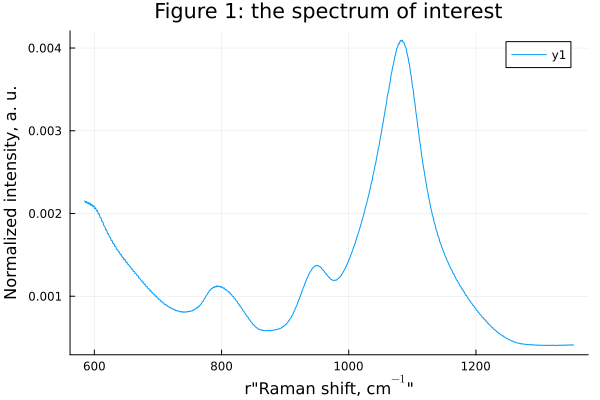

In [88]:
# get the spectrum to deconvolute, with skipping header and footer comment lines from the spectrometer
data = readdlm("./data/LS4.txt", '\t', Float64)

# To skip header and footer lines
skip_header = 23
skip_footer = 121
inputsp = zeros(size(data)[1]-skip_header-skip_footer,2)
j = 1
for i = skip_header+1:size(data)[1]-skip_footer
    inputsp[j,1] = Float64(data[i,1])
    inputsp[j,2] = Float64(data[i,2])
    j = j + 1
end

# performing the long correction; not always necessary at frequencies > 500 cm-1, 
# but this is just for the sack of example in the present case
x, y, ese_y = tlcorrection(inputsp, 23.0, 490.0)

# create a new plot for showing the spectrum
plot(x, y, 
xlabel=r"Raman shift, cm$^{-1}$", 
ylabel="Normalized intensity, a. u.",
title="Figure 1: the spectrum of interest")

So we are looking at the 500-1300 cm$^{-1}$ portion of the Raman spectrum of the glass. We see a peak near 800 cm$^{-1}$, and two others near 950 and 1085 cm$^{-1}$. We will be interested in fitting the 870-1300 cm$^{-1}$ portion of this spectrum, which can be assigned to the various symmetric and assymetric stretching vibrations of Si-O bonds in the SiO$_2$ tetrahedra present in the glass network (see the above cited litterature for details).

## Baseline Removal

First thing we notice in Fig. 1, we have to remove a baseline because this spectrum is shifted from 0 by some "background" scattering. This quite typical in Raman spectra of glasses. Several ways exist to do so. We're going to the simplest thing: a polynomial fitting the signal base around 870 and 1300 cm$^{-1}$. Other reasonnable solutions include a linear function, and a constant function. The two latter can be fitted between 1300 and 1350 cm$^{-1}$, but we will need to add another peak around 800 cm$^{-1}$. For now, the example is done with fitting the 870 cm$^{-1}$ portion of spectra, as this usually results in more robust final results.


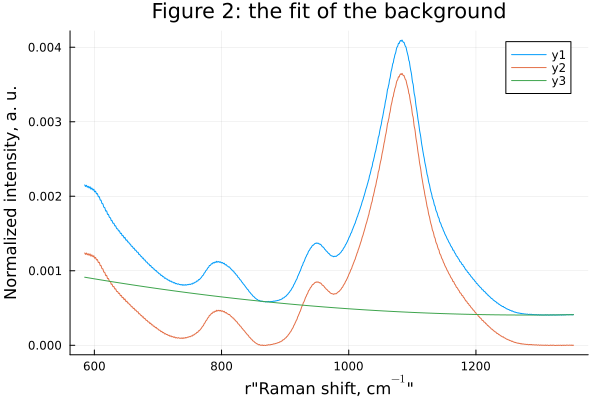

In [89]:
# the regions of interest roi
roi = [860.0 870.0; 1300.0 1400.0]

y_corr, y_bas = baseline(x, y, roi=roi, method="polynomial", polynomial_order=2) 

#Creates a plot showing the baseline
plot(x, [y y_corr y_bas],
xlabel=r"Raman shift, cm$^{-1}$", 
ylabel="Normalized intensity, a. u.",
title="Figure 2: the fit of the background")

Now we will do some manipulation to have the interested portion of spectrum in a single variable, using `extract_signal`. We will assume that the errors have not been drastically affected by the correction process (in some case it can be, but this one is quite straightforward), such that we will use the initial relative errors stored in the "ese0" variable.

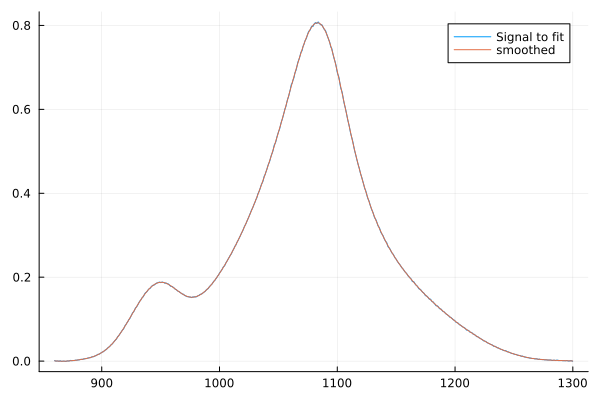

In [90]:
errors_corr = ese_y/y*y_corr
vector_spectrum_ese = extract_signal([[x y_corr], [x errors_corr]], [860. 1300.])
interest_spectrum = vector_spectrum_ese[1]
interest_error = vector_spectrum_ese[2]
x_fit = interest_spectrum[1]
y_fit = interest_spectrum[2]
ese_y_fit = interest_error[2]

# We will also normalise y_fit so that its area is equal to 100.
y_fit = normalise(y_fit; x=x_fit, method="area")*100

y_fit_perfect = smooth(x_fit, y_fit, method="whittaker", lambda=1e2)
ese_y_fit = sqrt.(mean((y_fit_perfect-y_fit).^2)) * ones(size(y_fit_perfect))

# Let's have a look at the signal
plot(x_fit, y_fit, label="Signal to fit")
plot!(x_fit, y_fit_perfect, label="smoothed")

# Fitting the spectrum

All the fitting will be done using JuMP, and the Ipopt solver. Good thing, you can change the solver as you want. JuMP is just a way to express things (a little bit like lmfit under python, but much more flexible).

There was a long speach at this point in the Python version of this notebook, but Julia allows to fit very easily the spectrum. It is quite obvious in the following lines that we create a model, we define the variables containing the peaks amplitudes, frequency and widths (hwhm), and we set them. 

If more or less peaks are needed, simply change the number of peaks (variable m), and adjust the initial parameters after the setValue function calls.

Constraints are possible to implement too, quite easily. Usually Ipopt gives a very good results without needing constraints.

 30.008730 seconds (17.07 M allocations: 24.919 GiB, 14.43% gc time, 20.44% compilation time)


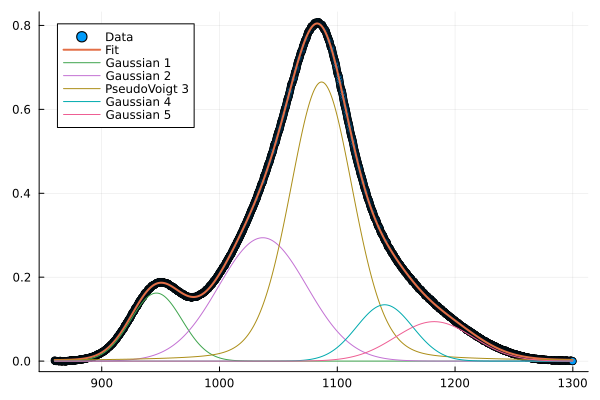

In [147]:
peaks_info = [
        # (type, initial_params, uncertainties, lower_bounds, upper_bounds)
        (:gaussian, [0.15, 945, 25.], [0.05, 0.5, 2.0], [0.0, 0.0, 0.0], [Inf, Inf, 60.0]),
        (:gaussian, [0.47, 1066, 25.], [0.05, 0.5, 2.0], [0.0, 0.0, 0.0], [Inf, Inf, 60.0]),
        (:pseudovoigt, [0.7, 1090, 25., 0.5], [0.001, 0.5, 2.0, 0.1], [0.0, 0.0, 0.0, 0.0], [Inf, Inf, 60.0, 1.0]),
        (:gaussian, [0.3, 1140, 25.], [0.05, 0.5, 2.0], [0.0, 0.0, 0.0], [Inf, Inf, 60.0]),
        (:gaussian, [0.05, 1190, 25.], [0.05, 0.5, 2.0], [0.0, 0.0, 0.0], [Inf, Inf, 60.0]),
    ]
@time result = fit_peaks(x_fit, y_fit, peaks_info; sigma=ese_y_fit, backend=:Optim)
result.plot_fit(components=true)

In [144]:
result.print_params()

Peak 1 (gaussian):
  amplitude: 0.1622 ± 0.0001
  center: 946.4133 ± 0.0198
  width: 25.5872 ± 0.022
Peak 2 (gaussian):
  amplitude: 0.294 ± 0.0005
  center: 1036.7423 ± 0.0919
  width: 44.1413 ± 0.0724
Peak 3 (pseudovoigt):
  amplitude: 0.6651 ± 0.0009
  center: 1086.6385 ± 0.0231
  width: 31.662 ± 0.0269
  fraction: 0.1947 ± 0.0021
Peak 4 (gaussian):
  amplitude: 0.1343 ± 0.0013
  center: 1140.2145 ± 0.0923
  width: 28.1513 ± 0.1206
Peak 5 (gaussian):
  amplitude: 0.0941 ± 0.0008
  center: 1182.2585 ± 0.3612
  width: 38.9521 ± 0.163


In [145]:
result2 = fit_peaks(x_fit, y_fit, peaks_info; sigma=ese_y_fit, backend=:qGN, relax=5.0, maxiter=100)
result2.print_params()

Peak 1 (gaussian):
  amplitude: 0.1622 ± 0.0001
  center: 946.4133 ± 0.0203
  width: 25.5872 ± 0.0228
Peak 2 (gaussian):
  amplitude: 0.294 ± 0.0006
  center: 1036.7423 ± 0.0972
  width: 44.1413 ± 0.0773
Peak 3 (pseudovoigt):
  amplitude: 0.6651 ± 0.0009
  center: 1086.6385 ± 0.0257
  width: 31.662 ± 0.0307
  fraction: 0.1947 ± 0.0023
Peak 4 (gaussian):
  amplitude: 0.1343 ± 0.0014
  center: 1140.2145 ± 0.1015
  width: 28.1513 ± 0.1269
Peak 5 (gaussian):
  amplitude: 0.0941 ± 0.0008
  center: 1182.2585 ± 0.3894
  width: 38.9521 ± 0.1876


In [116]:
result.peak_results

5-element Vector{Any}:
 (type = :gaussian, params = [0.16217271308708808, 946.41333191755, 25.587166843085882], errors = [0.0001407200280215046, 0.020264001476294907, 0.022778021694471275], area = 8.834097520377142)
 (type = :gaussian, params = [0.2940338685462393, 1036.7423431477425, 44.14127357357148], errors = [0.0005873616569735572, 0.09718044361344295, 0.0772501184799409], area = 27.631497547894618)
 (type = :pseudovoigt, params = [0.6650829350046596, 1086.6385318447328, 31.661987719313508, 0.805261465296046], errors = [0.000944412528354233, 0.025721439915017342, 0.030667110830238063, 0.0023127586955046585], area = 62.00249516652831)
 (type = :gaussian, params = [0.1342785990020687, 1140.2145392728144, 28.151276739459583], errors = [0.0013902970936496145, 0.10154094593691176, 0.126905109147427], area = 8.047613366858316)
 (type = :gaussian, params = [0.09405435482775576, 1182.258530822262, 38.95207475396825], errors = [0.0007951255522469779, 0.38942136413446604, 0.1876227741210441

In [158]:
test = 0.00123

0.00123

In [161]:
round.(test, sigdigits=2)

0.0012

In [148]:
# for Bayesian peak fitting example
using Turing

# Define a Bayesian model with priors
@model function bayesian_peaks(x, y)
    # Define priors based on peak_types
    
    # PEAK 1
    amplitude ~ truncated(Normal(0.16, 0.05), 0.0, Inf)
    center ~ Normal(946.0, 2.0)
    width ~ truncated(Normal(25.5, 2.0), 0.0, Inf)
    
    μ = gaussian(x, [amplitude, center, width])
    
    # PEAK 2
    amplitude2 ~ truncated(Normal(0.29, 0.5), 0.0, Inf)
    center2 ~ Normal(1036.7, 0.5)
    width2 ~ truncated(Normal(44.1, 0.5), 0.0, Inf)
    
    μ2 = gaussian(x, [amplitude2, center2, width2])
    
    # PEAK 3
    amplitude3 ~ truncated(Normal(0.66, 0.5), 0.0, Inf)
    center3 ~ Normal(1086.0, 2.0)
    width3 ~ truncated(Normal(31.6, 0.5), 0.0, Inf)
    lr ~ truncated(Normal(0.8, 0.03), 0.0, 1.0)
    
    μ3 = pseudovoigt(x, [amplitude3, center3, width3, lr])
    
    # PEAK 4
    amplitude4 ~ truncated(Normal(0.13, 0.05), 0.0, Inf)
    center4 ~ Normal(1140.0, 2.0)
    width4 ~ truncated(Normal(28.0, 1.0), 0.0, Inf)
    
    μ4 = gaussian(x, [amplitude4, center4, width4])
    
    # PEAK 5
    amplitude5 ~ truncated(Normal(0.09, 0.5), 0.0, Inf)
    center5 ~ Normal(1182.25, 10.0)
    width5 ~ truncated(Normal(38.95, 0.5), 0.0, Inf)
    
    μ5 = gaussian(x, [amplitude5, center5, width5])
    
    # Likelihood
    σ ~ truncated(Normal(0.002, 0.001), 0.0001, Inf)
    y ~ MvNormal(μ + μ2 + μ3 + μ4 + μ5, σ^2 * I)
end

#chain = sample(bayesian_peaks(x_fit, y_fit), NUTS(), 2000, nchains=3, progress=true)

bayesian_peaks (generic function with 2 methods)

In [149]:
md_ = bayesian_peaks(x_fit, y_fit)
map_estimate = maximum_a_posteriori(md_)

ModeResult with maximized lp of 10871.79
[0.1595738825391328, 946.1017383360859, 25.408602155883607, 0.3216937281947708, 1042.7234396370513, 47.72814998413976, 0.6004510282300478, 1086.635902686329, 30.516477881684906, 0.21738148856437053, 0.14209840151400113, 1137.8768523237443, 29.766069166984227, 0.0930531877642551, 1181.9732692210541, 39.59987496984923, 0.0015141123424754705]

In [150]:
chain = sample(bayesian_peaks(x_fit, y_fit), NUTS(), 1000, 
nchains=3, progress=true; initial_params=map_estimate.values.array)


┌ Info: Found initial step size
└   ϵ = 9.765625e-5
Sampling: 100%|█████████████████████████████████████████| Time: 0:18:33


Chains MCMC chain (1000×29×1 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 1130.54 seconds
Compute duration  = 1130.54 seconds
parameters        = amplitude, center, width, amplitude2, center2, width2, amplitude3, center3, width3, lr, amplitude4, center4, width4, amplitude5, center5, width5, σ
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters        mean       std      mcse   ess_bulk   ess_tail      rhat   ⋯
      Symbol     Float64   Float64   Float64    Float64    Float64   Float64   ⋯

   amplitude      0.1596    0.0003    0.0000   739.5881   647.5355    0.9995   ⋯
      center    946.1054    0.0433    0.0017   658.8188   626.8269    1.0016   ⋯
       width     25.4121    0.0458    0.0016   843.8997   704.7460    0.9992   ⋯
  

In [157]:
result.print_params(digits=4)

Peak 1 (gaussian):
  amplitude: 0.1622 ± 0.0001
  center: 946.4133 ± 0.0198
  width: 25.5872 ± 0.022
Peak 2 (gaussian):
  amplitude: 0.294 ± 0.0005
  center: 1036.7423 ± 0.0919
  width: 44.1413 ± 0.0724
Peak 3 (pseudovoigt):
  amplitude: 0.6651 ± 0.0009
  center: 1086.6385 ± 0.0231
  width: 31.662 ± 0.0269
  fraction: 0.1947 ± 0.0021
Peak 4 (gaussian):
  amplitude: 0.1343 ± 0.0013
  center: 1140.2145 ± 0.0923
  width: 28.1513 ± 0.1206
Peak 5 (gaussian):
  amplitude: 0.0941 ± 0.0008
  center: 1182.2585 ± 0.3612
  width: 38.9521 ± 0.163
